In [ ]:
!pip install transformers

In [ ]:
!pip install pytorch_lightning==1.8.0

In [ ]:
!pip install datasets

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tokenizers import Tokenizer

from datasets import load_dataset

import pytorch_lightning as pl

from IPython.display import display
from typing import List, Dict, Any, Tuple
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
class ApeachDataset(Dataset):
    def __init__(self,
                 split: str,
                 tokenizer: Tokenizer, 
                 max_length: int = 256,
                 padding: str = "max_length") -> None:
        super().__init__()
        dataset = load_dataset("jason9693/APEACH")
        texts = dataset[split]['text']
        inputs = tokenizer(texts, padding=padding, max_length=max_length, truncation=True, return_tensors="pt")
        
        self.input_ids = inputs["input_ids"]
        self.attention_masks = inputs["attention_mask"]
        
        labels = dataset[split]['class']
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return self.input_ids.shape[0]
        
    def __getitem__(self, index: Any) -> Dict:
        return self.input_ids[index], self.attention_masks[index], self.labels[index]

    def dataloader(self, **kwargs) -> DataLoader:
        return DataLoader(self, **kwargs)

In [ ]:
class ApeachStudentDataset(ApeachDataset):
    def __init__(self,
                 teacher_model: torch.nn.Module,
                 split: str,
                 teacher_tokenizer: Tokenizer, 
                 student_tokenizer: Tokenizer, 
                 max_length: int = 256,
                 padding: str = "max_length",
                 device: str="cuda") -> None:
        super().__init__(split, student_tokenizer, max_length, padding)
        
        teacher_ds = ApeachDataset(split, teacher_tokenizer, max_length, padding)

        teacher_model = teacher_model.to(device)
        with torch.no_grad():
            soft_labels = [self._get_soft_label(teacher_model, teacher_ds, i, device) 
                        for i in range(len(self))]
            self.soft_labels = torch.stack(soft_labels)

    def __getitem__(self, index: Any) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        return *super().__getitem__(index), self.soft_labels[index]

    def _get_soft_label(self, model, teacher_ds, index, device):
        ids, mask, _ = teacher_ds[index]
        ids = ids.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)
        return model(ids, mask).cpu().squeeze(0)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics.functional as tm
import pytorch_lightning as pl
from transformers import (
    AutoModelForSequenceClassification,
    BertForSequenceClassification,
)


def join_step_outputs(outputs):
    result = {}
    keys = outputs[0].keys()
    for k in keys:
        X = [x[k] for x in outputs]
        if X[0].dim() == 0:  # zero-dim tensor
            result[k] = torch.stack(X)
        else:
            result[k] = torch.cat(X, dim=0)
    return result


class TextClassificationModule(pl.LightningModule):
    def __init__(self, huggingface_model_name, labels, lr=5e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            huggingface_model_name, num_labels=len(labels)
        )
        # config = {
        #     "max_position_embeddings": 300,
        #     "hidden_dropout_prob": 0.1,
        #     "hidden_act": "gelu",
        #     "initializer_range": 0.02, # 12 to 2
        #     "num_hidden_layers": 2,
        #     "pooler_num_attention_heads": 12,
        #     "type_vocab_size": 2,
        #     "vocab_size": 30000,
        #     "hidden_size": 128, # 768 to 128
        #     "attention_probs_dropout_prob": 0.1,
        #     "num_attention_heads": 2, # 12 to 2
        #     "intermediate_size": 512, # 3072 to 512,
        #     "num_labels": len(labels)
        # }
        # self.model = BertForSequenceClassification(
        #     BertConfig(**config)
        # )
        self.multiclass = len(labels) > 1
        self.criterion = nn.CrossEntropyLoss() if self.multiclass else nn.BCELoss()
        self.labels = labels

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

    def forward(self, input_ids, attention_mask=None):
        logits = self.model(input_ids, attention_mask=attention_mask).logits
        if self.multiclass:
            logits = logits.softmax(dim=-1)
        else:
            logits = logits.sigmoid().squeeze(1).float()
        return logits

    def training_step(self, batch, batch_idx):
        ids, masks, labels = batch

        logits = self(ids, masks)
        loss = self.criterion(logits, labels)
        output = {"loss": loss, "logits": logits, "labels": labels}
        return output

    def training_epoch_end(self, outputs):
        outputs = join_step_outputs(outputs)
        loss = outputs["loss"].mean()
        self.log("train_epoch_loss", loss)

        logits = outputs["logits"]
        labels = outputs["labels"]
        acc = tm.accuracy(logits, labels.int())
        self.log(f"train_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        ids, masks, labels = batch
        logits = self(ids, masks)
        loss = self.criterion(logits, labels)
        output = {"loss": loss, "logits": logits, "labels": labels}
        return output

    def validation_epoch_end(self, outputs):
        outputs = join_step_outputs(outputs)
        loss = outputs["loss"].mean()
        self.log("val_epoch_loss", loss, prog_bar=True)

        logits = outputs["logits"]
        labels = outputs["labels"]
        acc = tm.accuracy(logits, labels.int())
        self.log(f"val_acc", acc, prog_bar=True)


In [ ]:
device = 'cuda'
#teacher_huggingface_model_name = 'beomi/KcELECTRA-base'

teacher_huggingface_model_name = 'monologg/koelectra-small-v3-discriminator'
student_hgf_model_name = 'monologg/koelectra-small-v3-discriminator'
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_huggingface_model_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_hgf_model_name)

curse_teacher = 'ckpt/hate_78.ckpt'
bias_teacher = 'ckpt/bias_val_epoch_loss=0.6996.ckpt'
hate_teacher = 'ckpt/hate_94_val_acc=0.7973.ckpt'
apeach_teacher = 'ckpt/hate_115_val_acc=0.8610.ckpt'

temp_teacher = '/content/drive/MyDrive/curse_model/hate_1_val_acc=0.7889.ckpt'

teacher_name = temp_teacher

teacher_module = TextClassificationModule.load_from_checkpoint(teacher_name, map_location=device)
labels = teacher_module.labels
print(labels)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

['hate']


In [ ]:
max_length = 32

train_ds = ApeachStudentDataset(
    teacher_module, 
    "train",
    teacher_tokenizer,
    student_tokenizer,
    max_length=max_length, 
    device=device)

val_ds = ApeachStudentDataset(
    teacher_module,
    "test",
    teacher_tokenizer,
    student_tokenizer,
    max_length=max_length, 
    device=device)

del teacher_module
del teacher_tokenizer

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7896 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3770 [00:00<?, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/jason9693___csv/default-13a19883aaaad80d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
ids, mask, label, soft_label = train_ds[3]
print(ids, mask, label, soft_label, len(train_ds))

tensor([    2,    21,    16,    22,  4162, 20476,  5618, 18781,    23,    16,
           24,  4162,  6598,  4129,  6406,  4034,  9753,  6395, 10976,  4820,
         4244,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) tensor(0.) tensor(0.0433) 7896


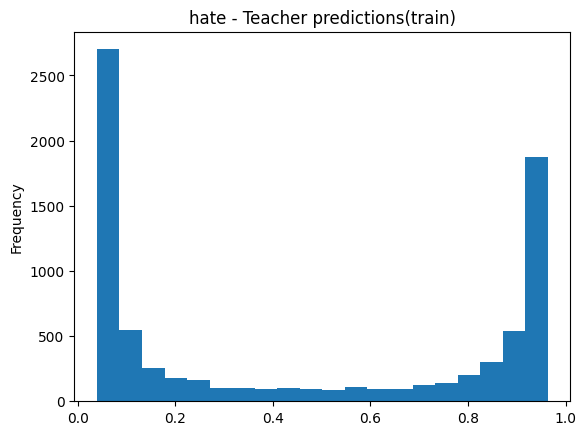

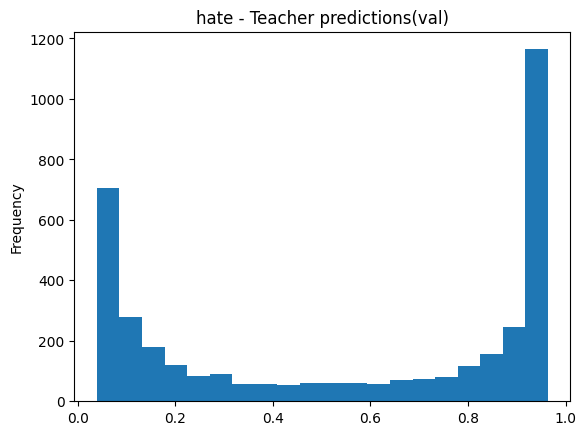

In [ ]:
import matplotlib.pyplot as plt


df = pd.DataFrame(train_ds.soft_labels.numpy(), columns=labels)
for label in labels:
    df[label].plot.hist(bins=20)
    plt.title(f"{label} - Teacher predictions(train)")
    plt.show()

df = pd.DataFrame(val_ds.soft_labels.numpy(), columns=labels)
for label in labels:
    df[label].plot.hist(bins=20)
    plt.title(f"{label} - Teacher predictions(val)")
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics.functional as tm
import pytorch_lightning as pl
from transformers import BertForSequenceClassification, AutoTokenizer


def join_step_outputs(outputs):
    result = {}
    keys = outputs[0].keys()
    for k in keys:
        X = [x[k] for x in outputs]
        if X[0].dim() == 0: # zero-dim tensor
            result[k] = torch.stack(X)
        else:
            result[k] = torch.cat(X, dim=0)
    return result


class TextClassificationStudentModule(pl.LightningModule):
    def __init__(self, config, labels, lr=5e-4, alpha=1.0):
        super().__init__()
        self.save_hyperparameters()
        if isinstance(config, str):
            self.model = AutoModelForSequenceClassification.from_pretrained(config, num_labels=len(labels))
        else:
            self.model = BertForSequenceClassification(config)
        self.multiclass = len(labels) > 1
        self.criterion = nn.CrossEntropyLoss() if self.multiclass else nn.BCELoss()
        self.soft_label_criterion = nn.BCELoss() # nn.KLDivLoss(reduction='batchmean')
        self.labels = labels
    
    def configure_optimizers(self):
        opt = optim.Adam(self.parameters(), lr=self.hparams.lr)
        return opt
        # sched = optim.lr_scheduler.StepLR(opt, 200, 0.5)
        # return [opt], [sched]

    def forward(self, input_ids, attention_mask=None):
        logits = self.model(input_ids, attention_mask=attention_mask).logits
        if self.multiclass:
            logits = logits.softmax(dim=-1)
        else:
            logits = logits.sigmoid().squeeze(1).float()
        return logits

    def _shared_step(self, batch):
        ids, masks, labels, soft_labels = batch
        alpha = self.hparams.alpha

        logits = self(ids, masks)
        ce_loss = self.criterion(logits, labels)
        kd_loss = self.soft_label_criterion(logits, soft_labels)
        loss = alpha * ce_loss + (1 - alpha) * kd_loss

        return {"loss": loss, "logits": logits, "labels": labels, 
                "ce_loss": ce_loss, "kd_loss": kd_loss}

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch)
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch)
    
    def _shared_epoch_end(self, outputs, stage):
        outputs = join_step_outputs(outputs)
        loss_names = ["loss", "ce_loss", "kd_loss"]
        for name in loss_names:
            loss = outputs[name].mean()
            self.log(f"{stage}_epoch_{name}", loss, prog_bar=True)

        logits = outputs["logits"]
        labels = outputs["labels"]
        acc = tm.accuracy(logits, labels.int(),task='binary')
        self.log(f"{stage}_acc", acc, prog_bar=True)
        
    def training_epoch_end(self, outputs):
        self._shared_epoch_end(outputs, "train")
        
    def validation_epoch_end(self, outputs):
        self._shared_epoch_end(outputs, "val")

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from transformers import BertConfig

batch_size = 64
alpha = 1.0

logger = pl.loggers.TensorBoardLogger(
    save_dir='.',
    name='lightning_logs'
)
save_dir = "./ckpt/"
checkpoint_callback = ModelCheckpoint(
    monitor="val_epoch_loss",
    dirpath=save_dir,
    filename=f"curse_{logger.version}",
    mode="min",
)
config = {
    "max_position_embeddings": 300,
    "hidden_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "initializer_range": 0.02, 
    "pooler_num_attention_heads": 12,
    "type_vocab_size": 2,
    "vocab_size": 30000,
    "attention_probs_dropout_prob": 0.1,
    "num_hidden_layers": 2,# 12 to 2(tiny), 4(small)
    "hidden_size": 512, # 768 to 128(tiny) 512(small)
    "num_attention_heads": 8, # 12 to 2(tiny) 8(small)
    "intermediate_size": 2048, # 3072 to 512(tiny), 2048(small)
    "num_labels": len(labels)
}
config = BertConfig(**config)
module = TextClassificationStudentModule(
    student_hgf_model_name,
    labels=labels,
    lr=5e-5,
    alpha=alpha
)
callbacks = [
    EarlyStopping("val_epoch_loss", mode="min", patience=10),
    checkpoint_callback,
    LearningRateMonitor("step")
]

trainer = pl.Trainer(max_epochs=1000, 
                logger=logger,
                gpus=1 if torch.cuda.is_available() else 0,
                val_check_interval=50,
                callbacks=callbacks)
trainer.fit(
    module,
    train_ds.dataloader(batch_size=batch_size),
    val_ds.dataloader(batch_size=batch_size))

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]